# Object Detection

본 핸즈온에선 COCO 데이터셋에서 사전 훈련된 모델을 파인튜닝하여 이미지에서 오토바이를 감지하는 모델을 AutoGluon으로 훈련합니다.
AutoGluon-Vision을 사용하면 단 몇 줄의 코드로 최적화된 모델을 쉽게 훈련할 수 있습니다.


In [1]:
import os
import autogluon.core as ag
from autogluon.vision import ObjectDetector

<br>

## 1. Data preparation and Training

이미지에서 오토바이를 감지하기 위한 toy 데이터셋을 수집합니다. 이 데이터셋은 23M에 불과하지만 VOC와 동일한 형식을 따르며, 훈련 이미지 120개, 검증 이미지 50개, 테스트 이미지 50개로 구성되어 있습니다.

### Data preparation

In [2]:
save_path = 'ag-03-object-detection'
!rm -rf $save_path

In [3]:
url = 'https://autogluon.s3.amazonaws.com/datasets/tiny_motorbike.zip'
train_dataset = ObjectDetector.Dataset.from_voc(url, splits='trainval')

tiny_motorbike/
├── Annotations/
├── ImageSets/
└── JPEGImages/


In [4]:
train_dataset.head(5)

,image,rois,image_attr
0,/home/ec2-user/.gluoncv/datasets/tiny_motorbik...,"[{'class': 'motorbike', 'xmin': 0.702, 'ymin':...","{'width': 500.0, 'height': 375.0}"
1,/home/ec2-user/.gluoncv/datasets/tiny_motorbik...,"[{'class': 'motorbike', 'xmin': 0.117117117117...","{'width': 333.0, 'height': 500.0}"
2,/home/ec2-user/.gluoncv/datasets/tiny_motorbik...,"[{'class': 'person', 'xmin': 0.102, 'ymin': 0....","{'width': 500.0, 'height': 432.0}"
3,/home/ec2-user/.gluoncv/datasets/tiny_motorbik...,"[{'class': 'motorbike', 'xmin': 0.226, 'ymin':...","{'width': 500.0, 'height': 375.0}"
4,/home/ec2-user/.gluoncv/datasets/tiny_motorbik...,"[{'class': 'motorbike', 'xmin': 0.357357357357...","{'width': 333.0, 'height': 500.0}"


### Training

아래 코드 셀을 실행하면, 두 번의 trial을 거치고 빠른 훈련을 위해 5 epoch만 훈련합니다. 하이퍼파라메터로 YOLOv3 기반 MobileNet과 ResNet 기반 SSD(Single Shot Multibox Detector) 모델을 선택적으로 사용하게 조정하였습니다. 실제 핸즈온에서는 설정을 간소화하였으므로 단일 모델만 훈련되지만, `num_trial`이나 `time_limit`을 조정하면 여러 모델들이 복합적으로 사용됩니다.

하이퍼파라메터 튜닝은 기본적으로 랜덤 검색(Random search)으로 설정되지만, `search_strategy = 'bayesopt'` 또는 `search_strategy = 'bayesopt_hyperband'` 옵션 또한 지원하고 있습니다.

In [5]:
time_limit = 60*4
detector = ObjectDetector(path=save_path)
hyperparameters = {'epochs': 5, 'batch_size': 8,
                  'transfer': ag.space.Categorical('yolo3_mobilenet1.0_coco', 'ssd_512_resnet50_v1_coco')}
hyperparamter_tune_kwargs = {'num_trials': 2}
detector.fit(train_dataset, time_limit=time_limit, 
             hyperparameters=hyperparameters, 
             hyperparamter_tune_kwargs=hyperparamter_tune_kwargs)

INFO:gluoncv.auto.tasks.object_detection:Randomly split train_data into train[151]/validation[19] splits.
INFO:gluoncv.auto.tasks.object_detection:Starting fit without HPO
INFO:YOLOv3Estimator:modified configs(<old> != <new>): {
INFO:YOLOv3Estimator:root.dataset_root    ~/.mxnet/datasets/ != auto
INFO:YOLOv3Estimator:root.train.seed      233 != 736
INFO:YOLOv3Estimator:root.train.epochs    20 != 5
INFO:YOLOv3Estimator:root.train.batch_size 16 != 8
INFO:YOLOv3Estimator:root.gpus            (0, 1, 2, 3) != (0,)
INFO:YOLOv3Estimator:root.yolo3.base_network darknet53 != mobilenet1.0
INFO:YOLOv3Estimator:root.yolo3.transfer  yolo3_darknet53_coco != yolo3_mobilenet1.0_coco
INFO:YOLOv3Estimator:root.valid.batch_size 16 != 8
INFO:YOLOv3Estimator:root.num_workers     4 != 8
INFO:YOLOv3Estimator:root.dataset         voc_tiny != auto
INFO:YOLOv3Estimator:}
INFO:YOLOv3Estimator:Saved config to /home/ec2-user/SageMaker/autogluon-hol/3.cv/ag-03-object-detection/30f3a5b9/.trial_0/config.yaml
INFO:YOL

<br>

## 2. Evaluation and Prediction

### Evaluation

In [12]:
detector.fit_summary()

{'train_map': 0.5375769463606852,
 'valid_map': 0.5375769463606852,
 'total_time': 75.65046763420105,
 'best_config': {'transfer': 'yolo3_mobilenet1.0_coco',
  'lr': 0.001,
  'num_trials': 1,
  'epochs': 5,
  'nthreads_per_trial': 128,
  'ngpus_per_trial': 8,
  'time_limits': 240,
  'search_strategy': 'random',
  'dist_ip_addrs': None,
  'log_dir': 'ag-03-object-detection/30f3a5b9',
  'batch_size': 8,
  'num_workers': 8,
  'gpus': [0],
  'seed': 736,
  'final_fit': False,
  'wall_clock_tick': 1616047841.4039707},
 'fit_history': {'train_map': 0.5375769463606852,
  'valid_map': 0.5375769463606852,
  'total_time': 75.65046763420105,
  'best_config': {'transfer': 'yolo3_mobilenet1.0_coco',
   'lr': 0.001,
   'num_trials': 1,
   'epochs': 5,
   'nthreads_per_trial': 128,
   'ngpus_per_trial': 8,
   'time_limits': 240,
   'search_strategy': 'random',
   'dist_ip_addrs': None,
   'log_dir': 'ag-03-object-detection/30f3a5b9',
   'batch_size': 8,
   'num_workers': 8,
   'gpus': [0],
   'seed':

In [6]:
test_dataset = ObjectDetector.Dataset.from_voc(url, splits='test')

test_map = detector.evaluate(test_dataset)
print("mAP on test dataset: {}".format(test_map[1][-1]))

tiny_motorbike/
├── Annotations/
├── ImageSets/
└── JPEGImages/
mAP on test dataset: 0.00517165504693221


In [7]:
def plot_bbox(img_path, result, threshold=0.5):
    
    import numpy as np
    import random
    import matplotlib.patches as patches
    import matplotlib.pyplot as plt
    from PIL import Image
    
    img = Image.open(img_path)    
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.imshow(img)
    w,h = img.size

    result = result[result['predict_score'] > threshold] 
    n_cls_preds = len(result)
    
    # Get bounding-box colors
    cmap = plt.get_cmap('tab20b')
    bbox_colors = [cmap(i) for i in np.linspace(0, 1, n_cls_preds)]
    random.seed(0)
    random.shuffle(bbox_colors)
    
    for i in range(n_cls_preds-1, -1, -1):
        bbox = result.iloc[i]['predict_rois']
        pred_cls = result.iloc[i]['predict_class']
        pred_score = result.iloc[i]['predict_score']
        label = '{} {:.2f}'.format(pred_cls, pred_score)
        color = bbox_colors[i]

        # Get box height and width
        x1 = bbox['xmin'] * w
        x2 = bbox['xmax'] * w
        y1 = bbox['ymin'] * h
        y2 = bbox['ymax'] * h

        # Get box height and width
        box_h = y2 - y1
        box_w = x2 - x1

        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=3, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)

        plt.text(x1, y1, s=label, color='white', verticalalignment='top',
                         bbox={'color': color, 'pad': 0})    

### Prediction

추론 결과는 표준적인 결과인 bounding box와 클래스 정보 및 score를 리턴하므로, 사용자 정의 함수나 GluonCV의 빌트인 함수로 쉽게 확인할 수 있습니다. 본 핸즈온에서는 사용자 정의 함수로 bounding box를 출력합니다.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


   predict_class  predict_score  \
0         person       0.680366   
1      motorbike       0.536413   
2        bicycle       0.233932   
3      motorbike       0.131007   
4      motorbike       0.065344   
5         person       0.050516   
6            car       0.040294   
7      motorbike       0.017907   
8    pottedplant       0.016063   
9      motorbike       0.015819   
10     motorbike       0.012952   
11   pottedplant       0.012002   

                                         predict_rois  
0   {'xmin': 0.38940903544425964, 'ymin': 0.223331...  
1   {'xmin': 0.34308749437332153, 'ymin': 0.488654...  
2   {'xmin': 0.34308749437332153, 'ymin': 0.488654...  
3   {'xmin': 0.0003285657148808241, 'ymin': 0.6003...  
4   {'xmin': 0.712922215461731, 'ymin': 0.38375955...  
5   {'xmin': 0.712922215461731, 'ymin': 0.38375955...  
6   {'xmin': 0.00653099874034524, 'ymin': 0.641152...  
7   {'xmin': 0.38940903544425964, 'ymin': 0.223331...  
8   {'xmin': 0.0003285657148808241, 'ymi

<Figure size 432x288 with 0 Axes>

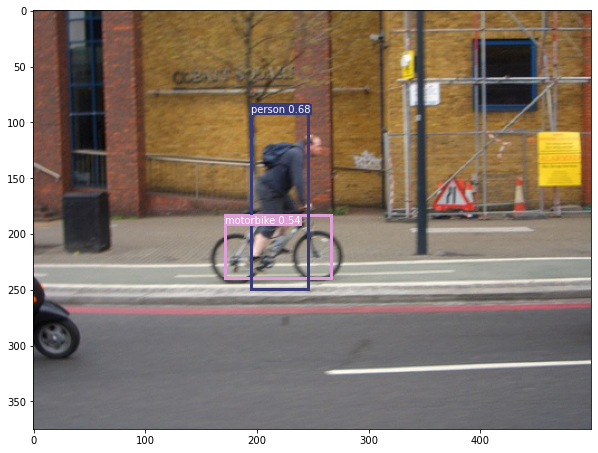

In [8]:
test_idx = 0
image_path = test_dataset.iloc[test_idx]['image']
result = detector.predict(image_path)
print(result)
plot_bbox(image_path, result)

### Save and load detectors

In [9]:
filename = os.path.join(save_path, 'detector.ag')
detector.save(filename)
detector_loaded = ObjectDetector.load(filename)
# use detector_loaded as usual
result = detector_loaded.predict(image_path)
print(result)

   predict_class  predict_score  \
0         person       0.680366   
1      motorbike       0.536413   
2        bicycle       0.233932   
3      motorbike       0.131007   
4      motorbike       0.065344   
5         person       0.050516   
6            car       0.040294   
7      motorbike       0.017907   
8    pottedplant       0.016063   
9      motorbike       0.015819   
10     motorbike       0.012952   
11   pottedplant       0.012002   

                                         predict_rois  
0   {'xmin': 0.38940903544425964, 'ymin': 0.223331...  
1   {'xmin': 0.34308749437332153, 'ymin': 0.488654...  
2   {'xmin': 0.34308749437332153, 'ymin': 0.488654...  
3   {'xmin': 0.0003285657148808241, 'ymin': 0.6003...  
4   {'xmin': 0.712922215461731, 'ymin': 0.38375955...  
5   {'xmin': 0.712922215461731, 'ymin': 0.38375955...  
6   {'xmin': 0.00653099874034524, 'ymin': 0.641152...  
7   {'xmin': 0.38940903544425964, 'ymin': 0.223331...  
8   {'xmin': 0.0003285657148808241, 'ymi